# Подбор параметров для расчета сезонности для рядов из базы данных SQLite

<p>Выбор алгоритма снятия сезонности, сравнение алгоритмов, подбор параметров</p>
<p>В качестве источника рядов в этой тетради используются файлы базы данных SQLite3, в формате базы данных ЦМАКП</p>
<p>Исходный файл должен быть устроен следующим образом:</p>  
<ul>
    <li>Каждый файл базы данных содержит ряды с определенным временным интервалом - годовые, квартальные, помесячные и т.д.</li>
    <li>Каждый файл базы данных содержит две таблицы: headers и datas. В headers содержаться заголовки рядом: название, описание, код ряда, параметры производных расчетов (в том числе и сезонности). В таблице datasсодержатся значения рядов. Таблицы связаны между собой через поле code - внутренний код базы данных. </li>
    <li>Поле code2 таблицы headers содержит уникальный внешний идентификатор ряда (строковый), по которому ряд можно выбрать в программе</li>
    <li>Поле params таблицы headers содержит параметры производных расчетов для каждого ряда. Параметры записаны в формате JSON. После подбора параметров снятия сезонности найденые параметры можно записать в это поле и использовать в дальнейшей работе</li>
    <li>Поля таблицы с данными (datas) строго определены: code - поле связи с таблицей headers; date - дата точки; value - цифровое значение точки</li>
</ul>

<p>Выборка ряда из базы данных в вышеописанных форматах осуществляется sql-запросом:</p>

><code>select * from datas inner join headers on headers.code=datas.code where headers.code2="{row_code}"</code>

<p>где row_code - внешний идентификатор ряда (например, 'Qr_X_Gdp') </p>
<p></p>
<p>Конечно, для выборки ряда необходимо указать путь к файлу SQLite3. </p>
<p></p>
<p>Ряд выбирается в объект pandas DataFrame, дальнейшая работа происходит именно с этим объектом</p>


<div class="alert alert-block alert-info">
<b>Внимание! Эта страница является шаблоном</b>. Если вам необходимо сохранить страницу для выбора 
алгоритма сезонности для определенного ряда, воспользуйтей командой 'File-Save as', и сохраните тетрадь с выполненными расчетами 
под отдельным именем. <br>
Данная тетрадь является файлом read-only
</div>

## Подбор функции снятия сезонности

<p>В данный момент к этой тетради подключено 3 функции сезонности: одна из библиотеки cmasf (<a href="https://github.com/GeorgyGol/cmasf">seasonal_docompose</a>) ; две - из библиотеки <a href="https://www.statsmodels.org/devel/index.html">statsmodels</a> (<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html">tsa.seasonal.seasonal_decompose</a> - на основе скользящего среднего и <a ref="https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html">tsa.seasonal.STL</a> - алгоритм <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html">LOESS</a>)</p>

### Алгоритм работы

<ol>
    <li>читаем выбранный ряд в обьект pandas DataFrame</li>
    <li>снимаем сезоность выбранным алгоритмом (или алгоритмами). Полученные тренды добавляются к DataFrame в виде новых столбцов</li>
    <li>строим график "исходный ряд + полученные тренды"</li>
    <li>меняем параметры алгоритмов, смотрим, как меняется график</li>
    <li>выбираем оптимальный алгоритм снятия сезонности, оптимальные параметры, записываем из в поле params таблицы headers для соттветствующего ряда</li>
    <li>повторяем операции для других рядов. В случае смены временого интервала ряда не забываем менять путь к базе данных (для квартальных - один файл базы данных, для помесячных - другой и т.д.)</li>
    <li>при необходимости можно сохранить выбранный ряд и тренды в csv-формате для анализа в другой программе</li>
</ol>

In [1]:
from cmasf import season as cmss # функция сезонности ЦМАКП
import statsmodels.tsa.seasonal as stmss
import os.path
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np
import json
import urllib.parse as urlparse
from urllib.parse import parse_qs
from IPython.display import Markdown as md

%matplotlib notebook
print(cmss.__version__)

# setup some output and print options

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

np.set_printoptions(precision = 3, linewidth =170)

0.0.3


## Загрузка ряда для работы
<div class="alert alert-block alert-warning">
<b>Путь к каталогу с базами данных:</b> Этот jupyther notebook может вызываться из другого блокнота - <b>"Установки и настройки модели АИЖК"</b> -там может быть задан альтернативный путь к каталогу с базами данных. <br>
</div>

### Путь к файлу с рядами, создание объекта connection для связи с выбранной базой

In [5]:
%%javascript
IPython.notebook.kernel.execute("URL = '" + window.location + "'");

<IPython.core.display.Javascript object>

In [6]:
strBasePath=r'../DB' # default path to sqlite-files catalog

parsed = urlparse.urlparse(URL)
try:
    strBasePath=parse_qs(parsed.query)['DATABASE'][0] # check database path from "Установки и настройки модели АИЖК"
except KeyError:
    pass

In [7]:
#select working DB-file:
strDBName='quar.sqlite3' # database for quarterly data --------------   month.sqlite3  ----------  year.sqlite3

strWorkDB=os.path.join(strBasePath, strDBName)
conn=sqlite3.connect(strWorkDB)

strMess='''<div class="alert alert-block alert-danger"><b>Работаем с базой данных {PATH_DB}</b></div>'''.format(PATH_DB=strWorkDB)
md(strMess)

<div class="alert alert-block alert-danger"><b>Работаем с базой данных /home/egor/git/jupyter/AIGK/DB/quar.sqlite3</b></div>

#### Заголовки рядов из выбранной базы данных
<p>Код <b>MGH</b> является специальным кодом группы рядов, ему не соответсвует ни один ряд, и в расчетах сезонности он не используется </p>
<p>В поле <b>params</b> приведены запомненные параметры предварительного расчета по соотв. ряду. Подоранные и запомненные параметры сезонности сохрянятся в этом поле в конце данной тетради</p>

In [11]:
strSQL_AllRowQuery='select code2, code, name, params from headers' # read only headers, print code2, code, row names and saved params

pdfHeaders=pd.read_sql(strSQL_AllRowQuery, con=conn)

# uncomment if you want to see headers with params
# display(pdfHeaders)
# print(pdfHeaders.shape)

#### Список кодов

In [12]:
print('CODE\t\t\tNAME')
print('='*80)
for _, r in pdfHeaders.iterrows():
    if r['code2']=='MGH':
        print()
    print('{code}\t{name}'.format(code=r.code2, name=r['name']))
    if r['code2']=='MGH':
        print('-'*80)
print('='*50)

CODE			NAME

MGH	МАКРОЭКОНОМИКА
--------------------------------------------------------------------------------
Qr_X_Gdp	Объем ВВП в сопоставимых ценах 2007 г.
Qr_S_Ind	Объем промышленного производства в сопоставимых ценах 2007 г.
Qr_I_build	Объем инвестиций в строительную отрасль (в ценах 2005 г.)
Qt_H_Inc	Денежные доходы (всего)
Qr_H_Wavg	Начисленная среднемесячная заработная плата в сопоставимых ценах 2007 г.
Qr_H_Incdsp	Реальные располагаемые денежные доходы в сопоставимых ценах 2007 г.
QT_D_M2new	Денежная масса (агрегат М2)
Q_L_Unemp_rate	Уровень безработицы в среднем за квартал
Ipc_P_Cpi	Индекс потребительских цен (цепной)
Q_D_Rtm_x	Обменный курс рубля, в среднем за квартал
P_E_$Urals_x	Цена нефти в среднем за квартал, Urals
Q_DKP_Rate	Ставка денежно-кредитной политики, в среднем за период
Qr_Con_Conf_I	Индекс потребительской уверенности (методология Росстата)
Qt_SOI_Crisis	Сводный опережающий индикатор макроэкономического кризиса (расчеты ЦМАКП)

MGH	ИПОТЕКА
-------------------

<a id='select_row' class='anchor'></a>
### Подбор параметров сезонности для выбранного ряда

In [13]:
# you must change some code below for select your working row
#============================================================

row_code='Qr_X_Gdp' #enter your row-code here 

#============================================================

In [14]:
strSQLQuery='select * from datas inner join headers on headers.code=datas.code where headers.code2="{row_code}"'
strGraphTitle='{row_name}({row_code})'

#read row from db, convert date to datetime type, make 'date' field as index
pdf=pd.read_sql(strSQLQuery.format(row_code=row_code), con=conn, 
                parse_dates=['date', ], index_col='date')

pdf['value'].head() # selected row data

date
2004-04-01    5948.124089
2004-07-01    6394.678266
2004-10-01    7179.403422
2005-01-01    7103.695190
2005-04-01    6279.979188
Name: value, dtype: float64

<IPython.core.display.Javascript object>


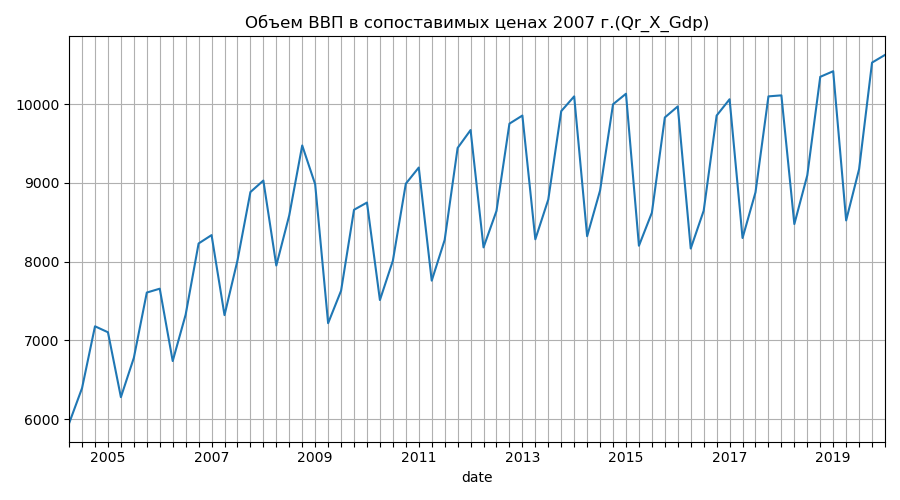

In [15]:
ax=pdf['value'].plot.line(figsize=(9, 5), grid=True, 
                          xticks=pdf.index, title=strGraphTitle.format(row_name=pdf['name'].values[0], row_code=row_code))

plt.tight_layout()
plt.show();

## Сезонная корректировка

<p><b>Читаем рабочие параметры сезонности из файла базы данных</b></p>
<p>Если у ряда нет параметров сезонности - создаем пустой набор параметров, инициализируемего значениями по умолчанию для каждой функции</p>
<p>Для каждой функции (метода) в соответствующей ячейке тетради можно изменить значения параметров - последние изменения сохраняются в соотв. переменной, их можно будет сохранить в базе данных</p>

In [9]:
%run -i prepare_read_season_params.py


field "params" for Qr_X_Gdp {"SEASON": {"working": "cmasf", "cmasf": {"period": 4, "static": 0, "model": "add", "gamma": 2, "opt_method": "bounded"}, "stl": {"period": 4, "seasonal": "default", "trend": "default", "low_pass": "default", "seasonal_deg": "default", "trend_deg": "default", "low_pass_deg": "default", "robust": "default", "seasonal_jump": "default", "trend_jump": "default", "low_pass_jump": "default"}}}
for row  Qr_X_Gdp
----------------------------------------
working algorithm -  cmasf
working params:
	period = 4
	static = 0
	model = add
	gamma = 2
	opt_method = bounded
----------------------------------------


<div class="alert alert-block alert-info" role="alert">
<p>используйте следующий шаблон для подбора параметров функции снятия сезонности</p>
<p>Параметры, имеющие значение 'default' для рассчета сезонности и для записи в базу данных использованы НЕ БУДУТ</p>
</div>

<p>для изменения-установки параметра используйте конструкцию (пример - для параметров функции снятия сезонности ЦМАКП):</p>

><code>cmasf_params['key']='your_value'</code>

<p>для сброса параметра используйте конструкцию:</p>

><code>cmasf_params['key']=str4def</code>

<div class="alert alert-block alert-warning" role="alert">
<p>Алгоритмы не обязательно запускать последовательно</p>
<p>Отсюда можно перейти непосредственно к тому, который нужен</p>
</div>
<ul>
    <li><a href="#cmasf">CMASF seasonal_decompose</a></li>
    <li><a href="#mov_av">statsmodesl.tsa moving average</a></li>
    <li><a href="#stl">statsmodesl.tsa STL (LOESS)</a></li>
</ul>

***

<a id='cmasf' class='anchor'></a>

### Алгоритм ЦМАКП (https://github.com/GeorgyGol/cmasf)

In [10]:
# help(cmss.seasonal_decompose) # uncomment it for view full help for function
# help (cmss.DecomposeResult) # uncomment it for view full help cmasf decompose result (this object returns from cmss.seasonal_decompose)


current params -  {'period': 4, 'static': 0, 'model': 'add', 'gamma': 2, 'opt_method': 'bounded'}


/home/egor/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


<IPython.core.display.Javascript object>


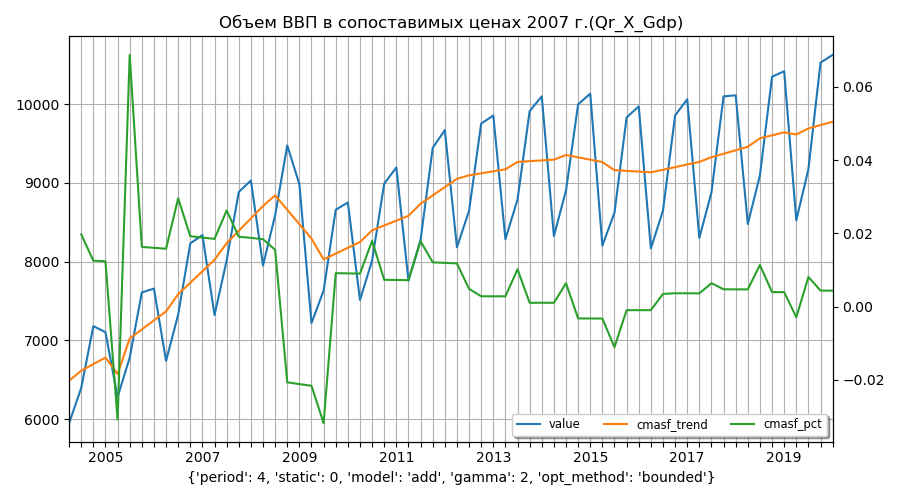

In [11]:
%run -i init_cmasf_params.py

# setup you params here:

cmasf_params['period']=4
cmasf_params['model']='add'
cmasf_params['static']=0
cmasf_params['precision']=str4def
cmasf_params['opt_method']='bounded'
cmasf_params['opt_bounds']=str4def

#=============================================================

c_pars={k:v for k, v in cmasf_params.items() if v !=str4def}
cmasf_res=cmss.seasonal_decompose(pdf['value'].values, **c_pars)
print('current params - ', c_pars)

pdf['cmasf_trend']=cmasf_res.trend
pdf['cmasf_pct']=pdf['cmasf_trend'].pct_change()
pdf['cmasf_wave']=cmasf_res.seasonal
# cmasf_res.plot(subplots=2) # un-comment it if you want to see wave and trend (and corrected row)

lst_plotted_rows=['value', 'cmasf_trend', 'cmasf_pct'] #, 'cmasf_wave'] # you can add wave or exclude pct? for ex.

ax_cmasf=pdf[lst_plotted_rows].plot.line(figsize=(9, 5), grid=True, xticks=pdf.index, secondary_y=['cmasf_pct',],
                          title=strGraphTitle.format(row_name=pdf['name'].values[0], row_code=row_code), legend=False)
ax_cmasf.set_xlabel(c_pars)

lines=ax_cmasf.get_lines() + ax_cmasf.right_ax.get_lines()
ax_cmasf.legend(handles=lines, labels=lst_plotted_rows, loc='lower right', ncol=3, fancybox=True, shadow=True, fontsize='small')

plt.tight_layout()
plt.show();

In [12]:
# run this if you want to see some algorithm optimization info
print('alg. working info: gamma={alfa}; iteration_cnt={iters}'.format(alfa=cmasf_res.weights, iters=cmasf_res.steps)) 

alg. working info: gamma=0.0003998040916498869; iteration_cnt=16


***
[Переход к сохранению параметров](#save_params)

[Переход к выбору нового ряда](#select_row)
***
(если вы не хотите использовать другие методы)

<a id="mov_av" class='anchor'></a>

### Алгоритм  <a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html">statsmodels.tsa.seasonal.seasonal_decompose</a>

In [13]:
# help(stmss.seasonal_decompose) # uncomment it for view full help for function


current params -  {'period': 4, 'model': 'additive', 'extrapolate_trend': 'freq'}


<IPython.core.display.Javascript object>


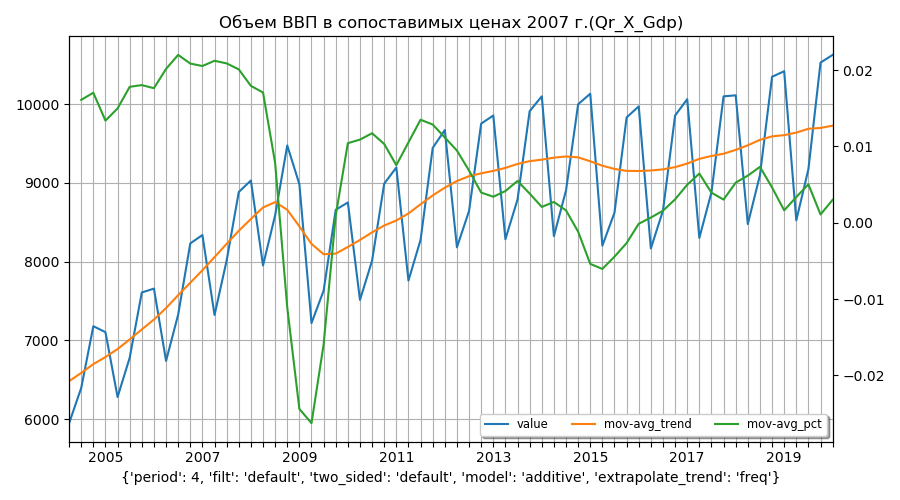

In [14]:
%run -i setup_mov_average_param.py

# setup you params here:

stmss_params['period']=4
stmss_params['model']='additive'
# stmss_params['model']='multiplicative'
# stmss_params['filt']=0
# stmss_params['two_sided']=True
stmss_params['extrapolate_trend']='freq'

#=========================

stm_pars={k:v for k, v in stmss_params.items() if v !=str4def}
stmss_res=stmss.seasonal_decompose(pdf['value'].values, **stm_pars)
print('current params - ', stm_pars)

pdf['mov-avg_trend']=stmss_res.trend
pdf['mov-avg_wave']=stmss_res.seasonal
pdf['mov-avg_pct']=pdf['mov-avg_trend'].pct_change()

# stmss_res.plot() # un-comment it if you want to see wave and trend (and corrected row)

lst_plt_mov_av_rows=['value', 'mov-avg_trend', 'mov-avg_pct'] #, 'mov-avg_wave'] # you can add wave or exclude pct? for ex.
ax_stmss=pdf[lst_plt_mov_av_rows].plot.line(figsize=(9, 5), grid=True, xticks=pdf.index, secondary_y=['mov-avg_pct',],
                          title=strGraphTitle.format(row_name=pdf['name'].values[0], row_code=row_code), legend=False)
ax_stmss.set_xlabel(stmss_params)

lines=ax_stmss.get_lines() + ax_stmss.right_ax.get_lines()
ax_stmss.legend(handles=lines, labels=lst_plt_mov_av_rows, loc='lower right', ncol=3, fancybox=True, shadow=True, fontsize='small')

plt.tight_layout()
plt.show();

***
[Переход к сохранению параметров](#save_params)


[Переход к выбору нового ряда](#select_row)

(если вы не хотите использовать другие методы)
***

<a id='stl' class='anchor'></a>
### Алгоритм  <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html">statsmodels.tsa.seasonal.STL</a>     


In [15]:
# help(stmss.STL) # uncomment it for view full help for function


current params -  {'period': 4}


<IPython.core.display.Javascript object>


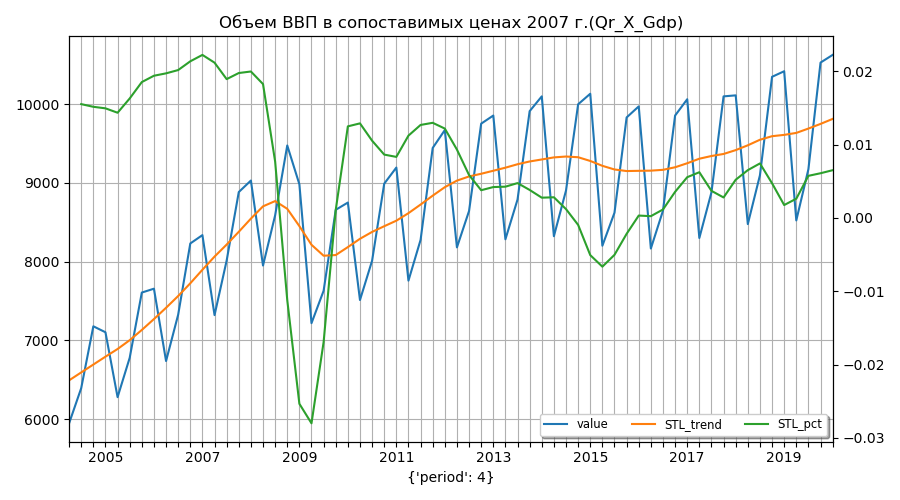

In [16]:
%run -i setup_stl_params.py

# setup you params here:

stmstl_params['period']=4

#=========================

stmstl_pars={k:v for k, v in stmstl_params.items() if v !=str4def}
stmstl_res=stmss.STL(pdf['value'].values, **stmstl_pars).fit()
print('current params - ', stmstl_pars)

pdf['STL_trend']=stmstl_res.trend
pdf['STL_wave']=stmstl_res.seasonal
pdf['STL_pct']=pdf['STL_trend'].pct_change()

# stmstl_res.plot() # un-comment it if you want to see wave and trend (and corrected row)

lst_plt_stl=['value', 'STL_trend', 'STL_pct']#, 'mov-STL_wave'] # you can add wave or exclude pct? for ex.

ax_stl=pdf[lst_plt_stl].plot.line(figsize=(9, 5), grid=True, xticks=pdf.index, secondary_y=['STL_pct', ],
                          title=strGraphTitle.format(row_name=pdf['name'].values[0], row_code=row_code), legend=False)

ax_stl.set_xlabel(stmstl_pars)

lines=ax_stl.get_lines() + ax_stl.right_ax.get_lines()

ax_stl.legend(handles=lines, labels=lst_plt_stl, loc='lower right', ncol=3, fancybox=True, shadow=True, fontsize='small')

plt.tight_layout()
plt.show();

***

[Переход к выбору нового ряда](#select_row)

***

## Сравнение методов

<IPython.core.display.Javascript object>


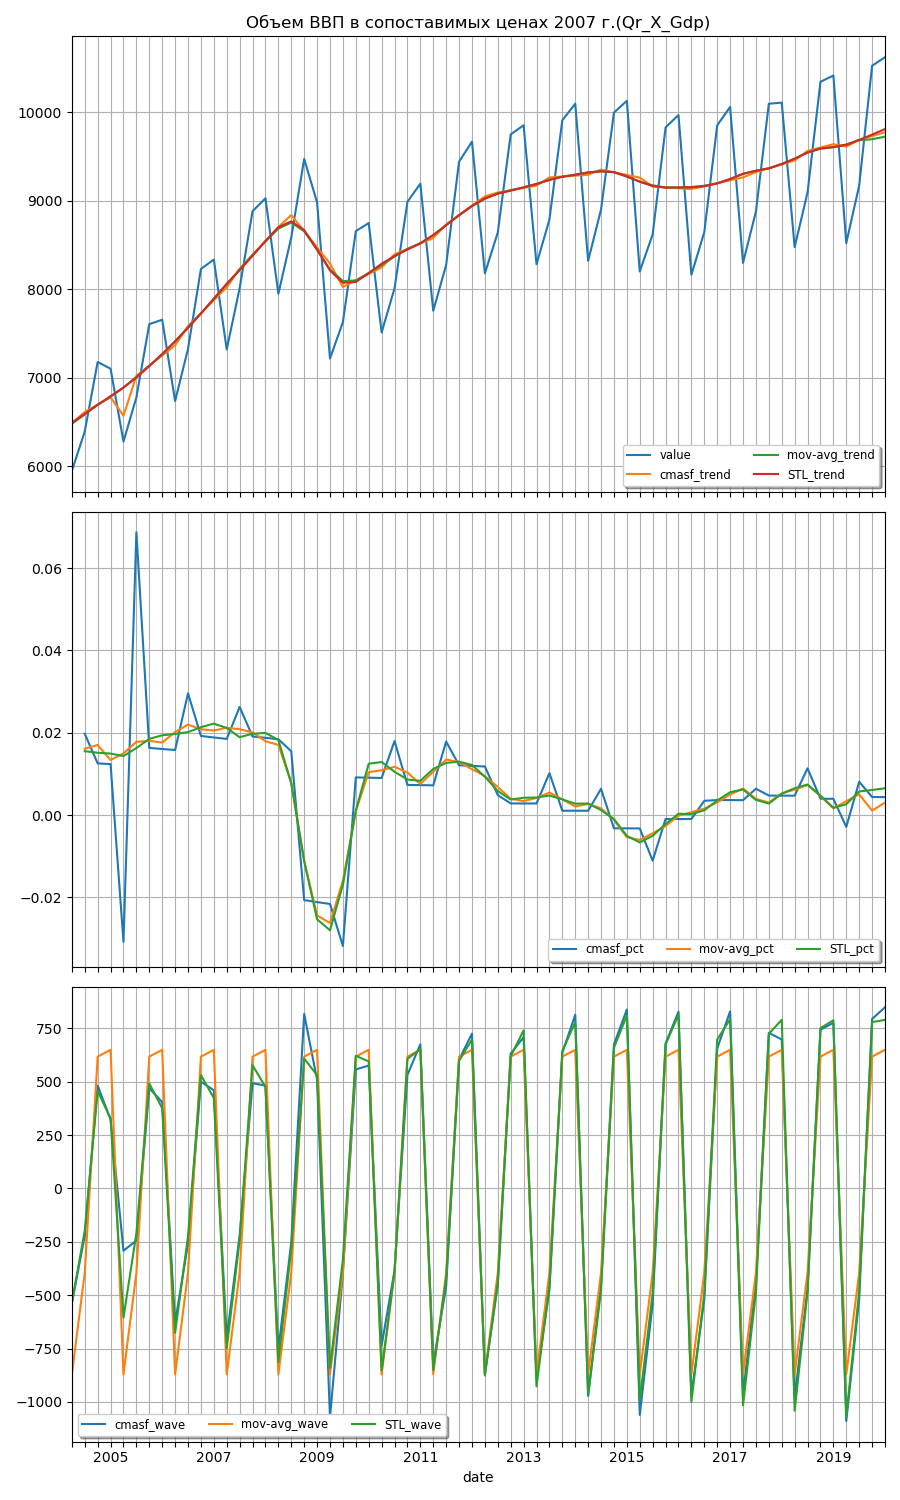

In [17]:
fig, axes=plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(9, 15))

pdf[['value', 'cmasf_trend', 'mov-avg_trend', 'STL_trend']].plot.line(grid=True, xticks=pdf.index, ax=axes[0],
                          title=strGraphTitle.format(row_name=pdf['name'].values[0], row_code=row_code))
pdf[['cmasf_pct', 'mov-avg_pct', 'STL_pct']].plot.line(grid=True, xticks=pdf.index, ax=axes[1])

pdf[['cmasf_wave', 'mov-avg_wave', 'STL_wave']].plot.line(grid=True, xticks=pdf.index, ax=axes[2])

axes[0].legend(loc='lower right', ncol=2, fancybox=True, shadow=True, fontsize='small')
axes[1].legend(loc='lower right', ncol=3, fancybox=True, shadow=True, fontsize='small')
axes[2].legend(loc='lower left', ncol=3, fancybox=True, shadow=True, fontsize='small')

plt.tight_layout()
plt.show();

## Выбор алгоритма, параметров, и запись в базу данных
<a id='save_params'></a>

In [23]:
# please select working alg. - cmasf, mov_av or stl

working_alg='cmasf' # 'mov_avg' # 'stl'

#==================================================

# stmstl_pars -> stl; stm_pars -> mov_avg;  c_pars >- cmasf
rd={'cmasf':{k:v for k, v in cmasf_params.items() if v !=str4def}, 
    'mov_avg':{k:v for k, v in stmss_params.items() if v !=str4def}, 
    'stl':{k:v for k, v in stmstl_params.items() if v !=str4def}}

working_params=rd[working_alg]
print('working alg. - ', working_alg )
print(working_params)

working alg. -  cmasf
{'period': 4, 'static': 0, 'model': 'add', 'gamma': 2, 'opt_method': 'bounded'}


### Сбор параметров в объект JSON

In [24]:
base_param['SEASON']['working']=working_alg
base_param['SEASON'][working_alg]=working_params

print(base_param)

{'SEASON': {'working': 'cmasf', 'cmasf': {'period': 4, 'static': 0, 'model': 'add', 'gamma': 2, 'opt_method': 'bounded'}, 'stl': {'period': 4, 'seasonal': 'default', 'trend': 'default', 'low_pass': 'default', 'seasonal_deg': 'default', 'trend_deg': 'default', 'low_pass_deg': 'default', 'robust': 'default', 'seasonal_jump': 'default', 'trend_jump': 'default', 'low_pass_jump': 'default'}}}


### Запись в базу данных

<div class="alert alert-danger" role="alert">
<p><b>Запись выбранного метода и его параметров в базу данных</b></p>
<p>Ошибочно записанные параметры придется стирать вручную в базе данных.</p>
<p><b>НЕ УВЕРЕН - НЕ ЗАПУСКАЙ!</b></p>
</div>

In [27]:
strSQLUpdate='update headers set params=? where code2="{code2}"'

conn.execute(strSQLUpdate.format(code2=row_code), (json.dumps(base_param),))
conn.commit()
print('All done')

All done


***

[Переход к выбору нового ряда](#select_row)

***